# **RNN Introduction**


## Importing required libraries


In [92]:
!pip install mplfinance
!pip install opendatasets
!pip install scikit-learn

In [93]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns

# Libraries for model training
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [94]:
# Reading our dataset
df = pd.read_csv('/content/traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [95]:
df.drop(columns=['ID'], inplace=True)

In [96]:
df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [98]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [99]:
df_filtered = df[(df['Junction'] == 1) &
                 (df['DateTime'].dt.hour >= 6) &
                 (df['DateTime'].dt.hour < 12)]

In [100]:
df_filtered_2 = df[(df['Junction'] == 1) &
                 (df['DateTime'].dt.hour >= 12) &
                 (df['DateTime'].dt.hour < 18)]

In [101]:
df_filtered['Vehicles'] = df_filtered['Vehicles'] / df_filtered['Vehicles'].max()

In [102]:
df_filtered_2['Vehicles'] = df_filtered_2['Vehicles'] / df_filtered_2['Vehicles'].max()

## Visualization

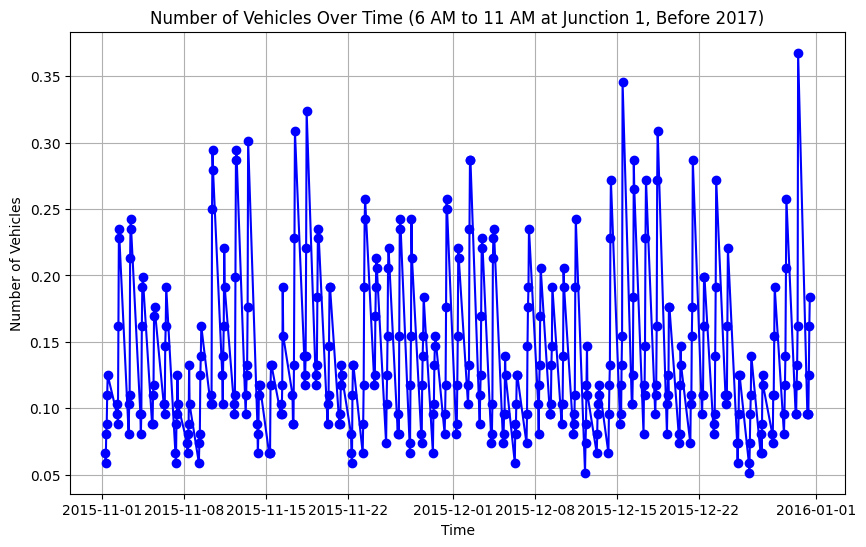

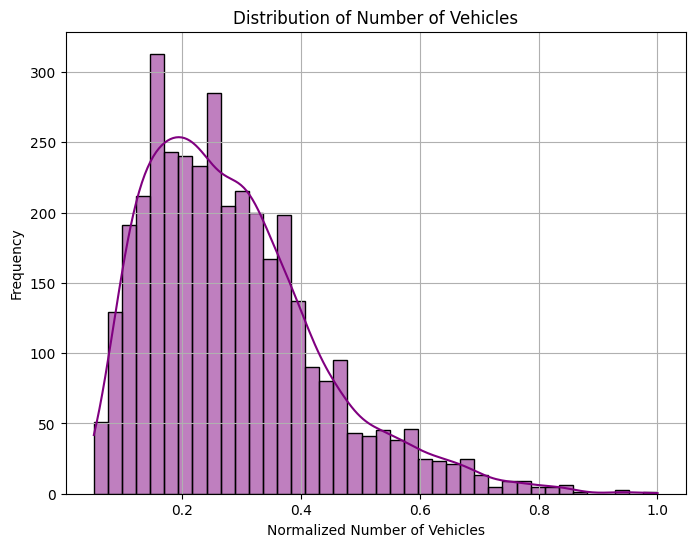

In [103]:

df_filtered_pre_2017 = df_filtered[df_filtered['DateTime'].dt.year < 2016]

plt.figure(figsize=(10, 6))
plt.plot(df_filtered_pre_2017['DateTime'], df_filtered_pre_2017['Vehicles'], marker='o', linestyle='-', color='b')
plt.title('Number of Vehicles Over Time (6 AM to 11 AM at Junction 1, Before 2017)')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df_filtered['Vehicles'], kde=True, color='purple')
plt.title('Distribution of Number of Vehicles')
plt.xlabel('Normalized Number of Vehicles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


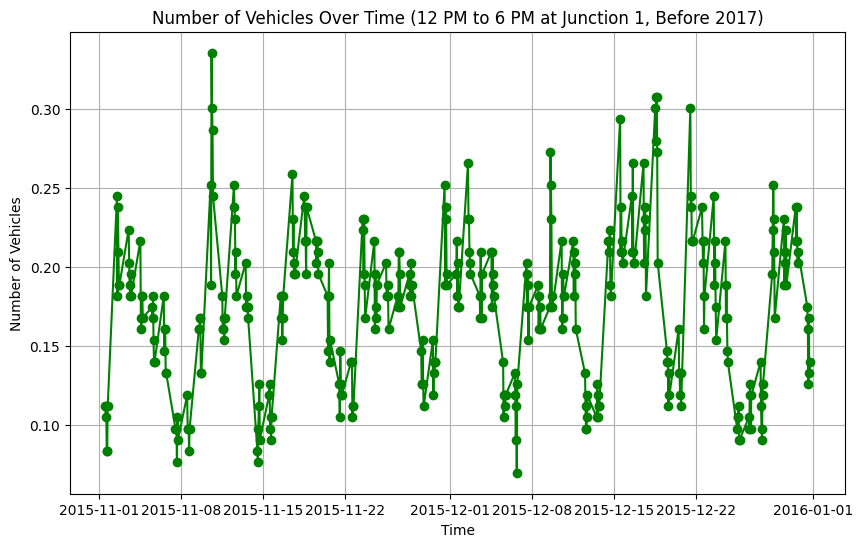

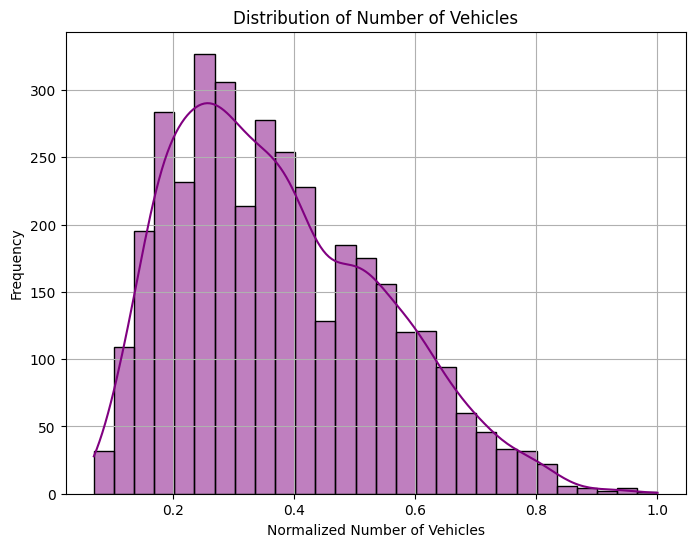

In [104]:

df_filtered_2_pre_2017 = df_filtered_2[df_filtered_2['DateTime'].dt.year < 2016]

plt.figure(figsize=(10, 6))
plt.plot(df_filtered_2_pre_2017['DateTime'], df_filtered_2_pre_2017['Vehicles'], marker='o', linestyle='-', color='green')
plt.title('Number of Vehicles Over Time (12 PM to 6 PM at Junction 1, Before 2017)')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df_filtered_2['Vehicles'], kde=True, color='purple')
plt.title('Distribution of Number of Vehicles')
plt.xlabel('Normalized Number of Vehicles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Split the data into train and test

In [105]:
sequence_length = 5
X = []
y = []

for i in range(len(df_filtered) - sequence_length):
    X.append(df_filtered.iloc[i:i+sequence_length]['Vehicles'].values)
    y.append(df_filtered.iloc[i+sequence_length]['Vehicles'])

X = np.array(X)
y = np.array(y)

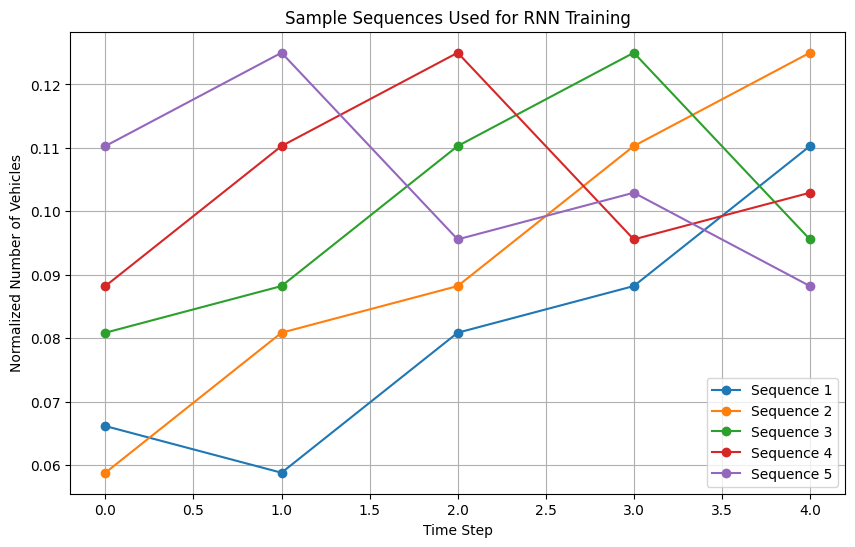

In [106]:

plt.figure(figsize=(10, 6))

for i in range(5):
    plt.plot(range(sequence_length), X[i], marker='o', linestyle='-', label=f'Sequence {i+1}')

plt.title('Sample Sequences Used for RNN Training')
plt.xlabel('Time Step')
plt.ylabel('Normalized Number of Vehicles')
plt.grid(True)
plt.legend()
plt.show()


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Modeling


In [108]:
model = Sequential()

model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))

model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(SimpleRNN(units=50))
model.add(Dropout(0.3))

model.add(Dense(units=1))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 5, 50)               │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 5, 50)               │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [110]:
checkpoint = ModelCheckpoint(filepath='Abd_weight_traffic.keras', save_best_only=True)

early_stoping = EarlyStopping(monitor='val_loss',patience=15, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=20,
          batch_size=6,
          verbose=1,
          callbacks= [checkpoint, early_stoping])

Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1138 - val_loss: 0.0114
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0209 - val_loss: 0.0100
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0157 - val_loss: 0.0098
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0136 - val_loss: 0.0097
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0136 - val_loss: 0.0101
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0121 - val_loss: 0.0100
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 10/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 11/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 12/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/ste

In [111]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [112]:
print(math.sqrt(mean_squared_error(y_train, train_predict)))


print(math.sqrt(mean_squared_error(y_test, test_predict)))

0.0942969293208641
0.09818668830081731


## Visualization of results


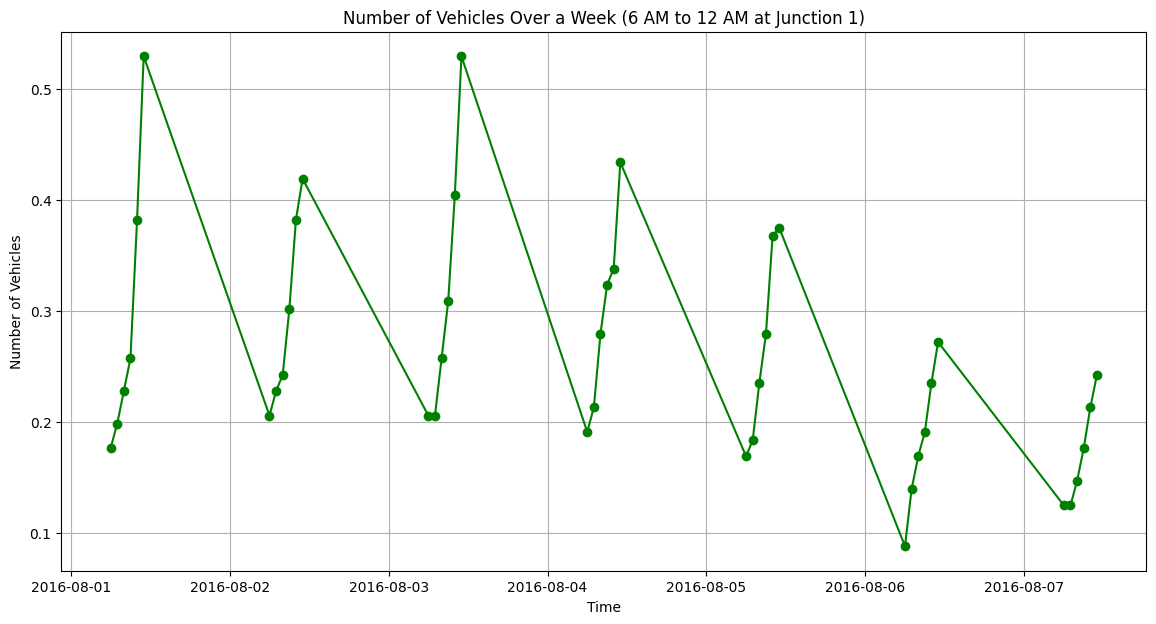

In [113]:
df_filtered['DateTime'] = pd.to_datetime(df_filtered['DateTime'])


plt.figure(figsize=(14, 7))
df_filtered_week = df_filtered[(df_filtered['DateTime'] >= '2016-08-01') & (df_filtered['DateTime'] < '2016-08-08')]
plt.plot(df_filtered_week['DateTime'], df_filtered_week['Vehicles'], marker='o', linestyle='-', color='green')
plt.title('Number of Vehicles Over a Week (6 AM to 12 AM at Junction 1)')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()

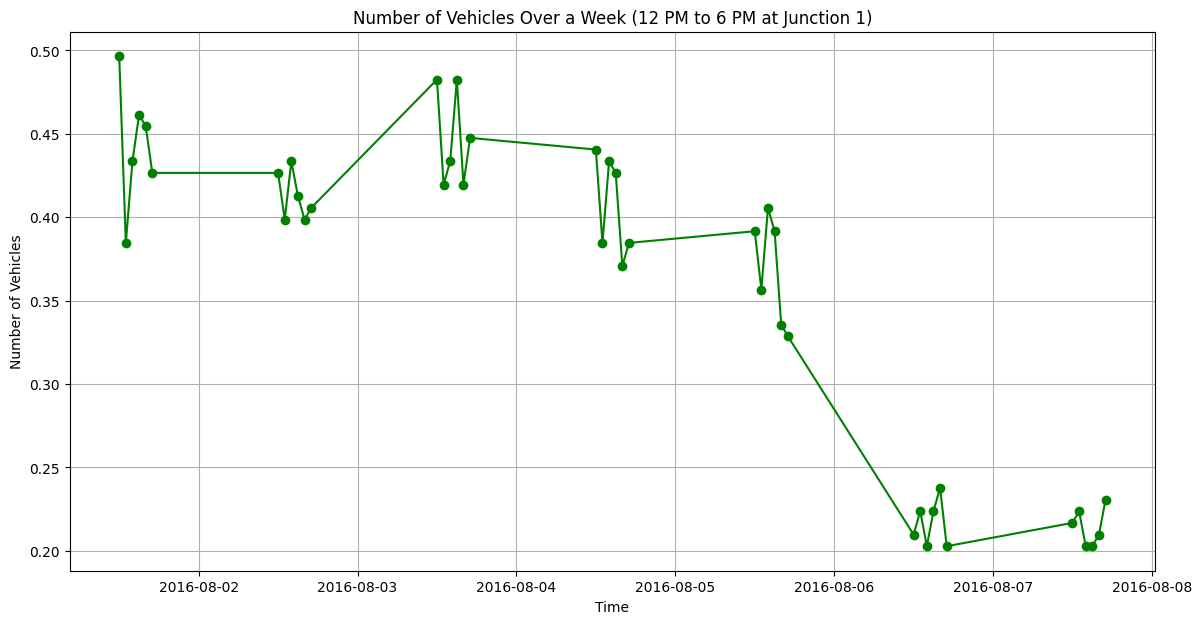

In [114]:
df_filtered_2['DateTime'] = pd.to_datetime(df_filtered_2['DateTime'])


plt.figure(figsize=(14, 7))
df_filtered_2_week = df_filtered_2[(df_filtered_2['DateTime'] >= '2016-08-01') & (df_filtered_2['DateTime'] < '2016-08-08')]
plt.plot(df_filtered_2_week['DateTime'], df_filtered_2_week['Vehicles'], marker='o', linestyle='-', color='green')
plt.title('Number of Vehicles Over a Week (12 PM to 6 PM at Junction 1)')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()

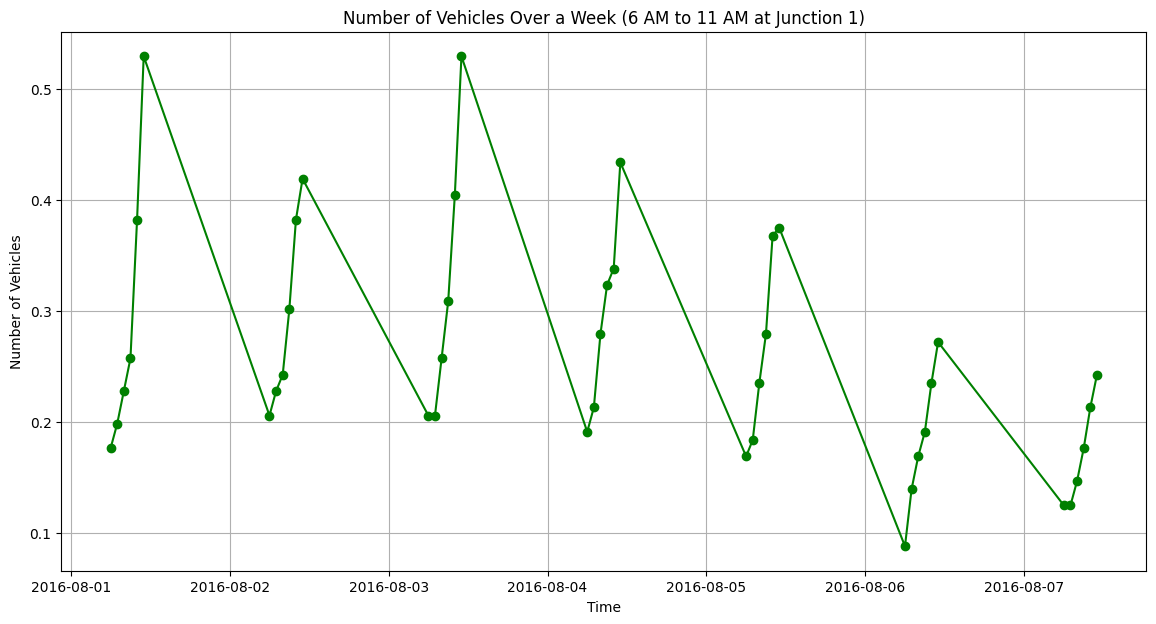

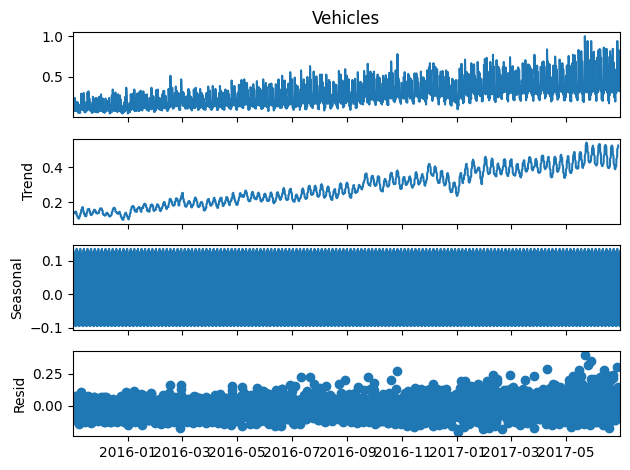

In [115]:

plt.figure(figsize=(14, 7))
df_filtered_week = df_filtered[(df_filtered['DateTime'] >= '2016-08-01') & (df_filtered['DateTime'] < '2016-08-08')]
plt.plot(df_filtered_week['DateTime'], df_filtered_week['Vehicles'], marker='o', linestyle='-', color='green')
plt.title('Number of Vehicles Over a Week (6 AM to 11 AM at Junction 1)')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()


df_filtered.set_index('DateTime', inplace=True)  # Set DateTime as index
decomposition = seasonal_decompose(df_filtered['Vehicles'], model='additive', period=24)


decomposition.plot()
plt.show()


### LMST

In [116]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0316
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0158
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0161
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0152
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0155
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0145
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0141
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0151
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0149
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0138
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0154
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0153
Epoch 13/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0139
Epoch 14/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0150
Epoch 15/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0139
Epoc

In [117]:
df_filtered_2_total = pd.concat(
    (
        df_filtered_2["Vehicles"][:2016],
        df_filtered_2["Junction"][2017:]
        ),
    axis=0
    )

inputs = df_filtered_2_total[len(df_filtered_2_total)-len(X_train) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = np.array(inputs)
print(inputs)

[[0.15384615]
 [0.15384615]
 [0.17482517]
 ...
 [1.        ]
 [1.        ]
 [1.        ]]


In [118]:
df_filtered_2_total = pd.concat(
    (
        df_filtered_2["Vehicles"][:2016],
        df_filtered_2["Junction"][2017:]
    ),
    axis=0
)
inputs = df_filtered_2_total.values
inputs = inputs.reshape(-1, 1)

print(inputs)

[[0.11188811]
 [0.1048951 ]
 [0.11188811]
 ...
 [1.        ]
 [1.        ]
 [1.        ]]


In [119]:
sc.fit(df_filtered_2_total.values.reshape(-1, 1))  # Fit the scaler to your data

MinMaxScaler()

In [120]:
X_test = []
for i in range(50,213):
    X_test.append(inputs[i-50:i,0]) # Now you can slice the array
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_Number_of_Vehicles = regressor.predict(X_test)
predicted_Number_of_Vehicles = sc.inverse_transform(predicted_Number_of_Vehicles)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


In [121]:
def plot_predictions(test_set,predicted_Number_of_Vehicles):
    pass

In [122]:
def return_rmse(test_set, predicted_Number_of_Vehicles):
  pass

In [123]:
from sklearn.model_selection import train_test_split

print("Shape of inputs:", inputs.shape)
print("Shape of y:", y.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

train_predict2 = regressor.predict(X_train)
print(math.sqrt(mean_squared_error(y_train,train_predict2)))

test_predict2 = regressor.predict(X_test)


Shape of inputs: (3647, 1)
Shape of y: (3643,)
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
0.11678445103234553
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


**GRU Model**

In [124]:
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
regressorGRU = Sequential()

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

regressorGRU.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0381
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0209
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0180
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0172
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0155
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0154
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0138
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0145
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0140
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0150


In [125]:
train_predict3=regressorGRU.predict(X_train)
test_predict3=regressorGRU.predict(X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [126]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(y_train.reshape(-1, 1))
train_predict3_2D = train_predict3.reshape(train_predict3.shape[0], -1)
test_predict3_2D = test_predict3.reshape(test_predict3.shape[0], -1)

train_predict3 = scaler.inverse_transform(train_predict3_2D).reshape(y_train.shape[0], 1)

print("Shape of test_predict3_2D:", test_predict3_2D.shape)

test_predict3 = scaler.inverse_transform(test_predict3_2D).reshape(test_predict3_2D.shape[0], 1)
print("Shape of test_predict3 after inverse transform:", test_predict3.shape)

Shape of test_predict3_2D: (163, 1)
Shape of test_predict3 after inverse transform: (163, 1)


In [127]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(y_train.reshape(-1, 1))

train_predict3_2D = train_predict3.reshape(train_predict3.shape[0], -1)
test_predict3_2D = test_predict3.reshape(test_predict3.shape[0], -1)

train_predict3 = scaler.inverse_transform(train_predict3_2D).reshape(y_train.shape[0], 1)

test_predict3 = scaler.inverse_transform(test_predict3_2D).reshape(test_predict3.shape[0], 1)

print(math.sqrt(mean_squared_error(y_train, train_predict3.reshape(-1)))) # Reshape to 1D

if len(y_test) != len(test_predict3):
    print("Warning: y_test and test_predict3 have different lengths!")
    print("Length of y_test:", len(y_test))
    print("Length of test_predict3:", len(test_predict3))
else:
    print(math.sqrt(mean_squared_error(y_test, test_predict3.reshape(-1)))) # Reshape to 1D

0.1457213575250744
Length of y_test: 729
Length of test_predict3: 163
